# Initial Setup

In [1]:
# Import packages

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

%matplotlib inline
import matplotlib.pyplot as plt

# !pip install torchsummary
from torchsummary import summary
from torchvision.utils import make_grid   # ✅ import added

from tqdm import tqdm

# Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [2]:
# # Train Phase transformations
# train_transforms = transforms.Compose([
#                                       #  transforms.Resize((28, 28)),
#                                        transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05),
#                                        transforms.ToTensor(),
#                                        transforms.Normalize((0.4914, 0.4822, 0.4465),
#                                                             (0.2023, 0.1994, 0.2010))

#                                        ])

# # Test Phase transformations
# test_transforms = transforms.Compose([
#                                       #  transforms.Resize((28, 28)),
#                                       #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
#                                        transforms.ToTensor(),
#                                        transforms.Normalize((0.4914, 0.4822, 0.4465),
#                                                             (0.2023, 0.1994, 0.2010))
#                                        ])


In [4]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from PIL import Image
import torch

# Wrapper so Albumentations can be used inside torchvision transforms.Compose
class AlbumentationsTransform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, img):
        # Convert PIL Image -> numpy array
        img = np.array(img)
        augmented = self.transform(image=img)
        img = augmented["image"]
        return img

# CIFAR10 mean/std
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)

# Albumentations
albumentations_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(
        shift_limit=0.1,
        scale_limit=0.1,
        rotate_limit=10,  # smaller rotation for CIFAR
        p=0.5
    ),
    A.CoarseDropout(
        num_holes_range=(1,1), hole_height_range=(16,16), hole_width_range=(16,16),
        fill=(0.4914, 0.4822, 0.4465),
        fill_mask=None,
        p=0.5



    ),
])

# Torchvision
train_transforms = transforms.Compose([
    # transforms.RandomCrop(32, padding=4),         # standard for CIFAR
    # transforms.RandomHorizontalFlip(p=0.5),       # common + simple
    # transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),   # slightly stronger jitter
    # transforms.RandomGrayscale(p=0.05),           # low prob, avoid killing color info
    AlbumentationsTransform(albumentations_transform),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    # transforms.RandomErasing(p=0.25, scale=(0.02, 0.15))  # stronger erasing than before
])

# --------------------------
# Test Phase transformations
# --------------------------
test_transforms = transforms.Compose([
    AlbumentationsTransform(A.Compose([ ])),   # empty wrapper (keeps format consistent)
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


# Dataset and Creating Train/Test Split

In [5]:
# Fetch CIFAR10 Data from internet
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

# # Load from local ./data folder
# train = datasets.CIFAR10(root="./data", train=True, download=False, transform=train_transforms)
# test = datasets.CIFAR10(root="./data", train=False, download=False, transform=test_transforms)


100%|██████████| 170M/170M [00:14<00:00, 11.8MB/s]


# Dataloader Arguments & Test/Train Dataloaders


In [6]:
SEED = 1

# Is CUDA available?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64) # So both the order of batches and the order of samples inside each batch can change, because the dataset's images' indices was shuffled before batching. But this is lazy exec; happen only when we use / call attributes of the class

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args) # this by default applies the transform

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

print(f"Train size: {len(train)}, Test size: {len(test)}")

CUDA Available? True
Train size: 50000, Test size: 10000


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

In [7]:
# # ---- Compute statistics from raw train.data (before normalization) ----
# train_data = torch.tensor(train.data)  # shape: (50000, 32, 32, 3)

# print('[Train Data Statistics BEFORE normalization]')
# print(' - Numpy Shape:', train.data.shape)
# print(' - Tensor Shape:', train_data.size())
# print(' - min:', torch.min(train_data.float()))
# print(' - max:', torch.max(train_data.float()))
# print(' - mean:', torch.mean(train_data.float()))
# print(' - std:', torch.std(train_data.float()))
# print(' - var:', torch.var(train_data.float()))

# # ---- After transforms (normalized) ----
# # Take a batch from DataLoader and check stats
# dataiter = iter(train_loader)
# images, labels = next(dataiter)

# print("\n[Batch Statistics AFTER normalization]")
# print(' - Images Shape:', images.shape)   # e.g. torch.Size([64, 3, 32, 32])
# print(' - Labels Shape:', labels.shape)   # e.g. torch.Size([64])
# print(' - min:', torch.min(images))
# print(' - max:', torch.max(images))
# print(' - mean:', torch.mean(images))
# print(' - std:', torch.std(images))




In [8]:
# # ---- Visualize a sample ----

# # Function to show random images each run
# def show_random_images(loader, classes, num_images=60):
#     # Grab a random batch
#     dataiter = iter(loader)
#     images, labels = next(dataiter)

#     # Undo normalization
#     mean = torch.tensor((0.4914, 0.4822, 0.4465)).view(3,1,1)
#     std  = torch.tensor((0.2470, 0.2435, 0.2616)).view(3,1,1)
#     images = images * std + mean  # denormalize

#     # Plot images
#     plt.figure(figsize=(6, 6))
#     for index in range(num_images):
#         plt.subplot(6, 10, index+1)   # 6 rows, 10 columns
#         plt.axis('off')
#         img = images[index].permute(1, 2, 0).numpy()  # C,H,W → H,W,C
#         plt.imshow(img)
#         plt.title(classes[labels[index]], fontsize=7)
#     plt.show()

# # Example usage
# show_random_images(train_loader, train.classes, num_images=60)


# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [9]:
# For plotting the train and test / vizualisation
train_losses = []
test_losses = []
train_acc = []
test_acc = []

# Train workflow
def train(model, device, train_loader, optimizer, epoch):
  model.train() # set to train mode
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    # Get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Calc accuracy
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    # Update pbar-tqdm
    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval() # set to
    test_loss = 0
    correct = 0

    # Test flow
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset) # average loss (from sum up batch loss) - because it's test; in training we get progress
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Final Arch

In [10]:
# Step 15: Friday's Exp 3: Improving on "Ran 120 EPochs"

# dropout_value = 0.025

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.inputblock = nn.Sequential(

            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), stride = 1, padding=1, bias=False), # stride 1 and padding 0 in 1x1 & no dropout
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # nn.Dropout(dropout_value),
            # RF = 3 | Output = 32 x 32
        )

        self.convblock1 = nn.Sequential(

            # Depthwise_1
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1, groups=32, bias=False),  # depthwise
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, bias=False),  # pointwise
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # nn.Dropout(dropout_value),
            # RF = 5 | Output = 32 x 32

            # Depthwise_2
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1, groups=32, bias=False),  # depthwise
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=1, bias=False),  # pointwise
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # nn.Dropout(dropout_value),
            # RF = 7 | Output = 16 x 16

        )


        self.convblock2 = nn.Sequential(

            # Depthwise_1
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, groups=64, bias=False),  # depthwise
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, bias=False),  # pointwise
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # nn.Dropout(dropout_value),
            # RF = 11 | Output = 16 x 16

            # Depthwise_2
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1, groups=64, bias=False),  # depthwise
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=1, bias=False),  # pointwise
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # nn.Dropout(dropout_value),
            # RF = 15 | Output = 8 x 8

        )


        self.convblock3 = nn.Sequential(

            # Depthwise_1
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1, groups=128, bias=False),  # depthwise
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=1, bias=False),  # pointwise
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # nn.Dropout(dropout_value),
            # RF = 23 | Output = 8 x 8

            # Depthwise_2
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1, groups=128, bias=False),  # depthwise
            nn.Conv2d(in_channels=128, out_channels=192, kernel_size=1, bias=False),  # pointwise
            nn.BatchNorm2d(192),
            nn.ReLU(),
            # nn.Dropout(dropout_value),
            # RF = 31 | Output = 4 x 4


        )


        self.convblock4 = nn.Sequential(

            # Depthwise_1
            nn.Conv2d(in_channels=192, out_channels=192, kernel_size=3, stride=1, padding=1, groups=192, bias=False),  # depthwise
            nn.Conv2d(in_channels=192, out_channels=192, kernel_size=1, bias=False),  # pointwise
            nn.BatchNorm2d(192),
            nn.ReLU(),
            # nn.Dropout(dropout_value),
            # RF = 47 | Output = 4 x 4

            # Depthwise_2 + Dilated
            nn.Conv2d(in_channels=192, out_channels=192, kernel_size=3, stride=1, padding=2, groups=192, dilation=2, bias=False),  # depthwise
            nn.Conv2d(in_channels=192, out_channels=256, kernel_size=1, bias=False),  # pointwise
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # nn.Dropout(dropout_value),
            # RF = 47 + | Output = 4 x 4

        )

        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Conv2d(256, 10, 1)


    def forward(self, x):
        x = self.inputblock(x)

        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)

        x = self.gap(x)
        x = self.fc(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [11]:
# Model Summary | Model Done
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device) # take NN to cuxda
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]             288
            Conv2d-5           [-1, 32, 32, 32]           1,024
       BatchNorm2d-6           [-1, 32, 32, 32]              64
              ReLU-7           [-1, 32, 32, 32]               0
            Conv2d-8           [-1, 32, 16, 16]             288
            Conv2d-9           [-1, 64, 16, 16]           2,048
      BatchNorm2d-10           [-1, 64, 16, 16]             128
             ReLU-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]             576
           Conv2d-13           [-1, 64, 16, 16]           4,096
      BatchNorm2d-14           [-1

In [12]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
EPOCHS = 80

from torch.optim.lr_scheduler import CosineAnnealingLR

scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)  # T_max = cycle length


for epoch in range(EPOCHS):
    print("EPOCH:", epoch, "LR:", scheduler.get_last_lr()[0])
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0 LR: 0.01


Loss=1.6094974279403687 Batch_id=390 Accuracy=33.25: 100%|██████████| 391/391 [00:27<00:00, 13.99it/s]



Test set: Average loss: 1.5102, Accuracy: 4440/10000 (44.40%)

EPOCH: 1 LR: 0.009996145566685495


Loss=1.3011925220489502 Batch_id=390 Accuracy=46.68: 100%|██████████| 391/391 [00:28<00:00, 13.86it/s]



Test set: Average loss: 1.3105, Accuracy: 5235/10000 (52.35%)

EPOCH: 2 LR: 0.009984588209998774


Loss=1.3815661668777466 Batch_id=390 Accuracy=53.05: 100%|██████████| 391/391 [00:26<00:00, 14.74it/s]



Test set: Average loss: 1.1493, Accuracy: 5898/10000 (58.98%)

EPOCH: 3 LR: 0.009965345750546155


Loss=1.1512222290039062 Batch_id=390 Accuracy=58.44: 100%|██████████| 391/391 [00:33<00:00, 11.54it/s]



Test set: Average loss: 0.9635, Accuracy: 6585/10000 (65.85%)

EPOCH: 4 LR: 0.009938447858805391


Loss=1.0572527647018433 Batch_id=390 Accuracy=61.25: 100%|██████████| 391/391 [00:27<00:00, 14.47it/s]



Test set: Average loss: 0.9705, Accuracy: 6538/10000 (65.38%)

EPOCH: 5 LR: 0.00990393600937595


Loss=1.084010124206543 Batch_id=390 Accuracy=63.99: 100%|██████████| 391/391 [00:26<00:00, 14.59it/s]



Test set: Average loss: 0.9117, Accuracy: 6765/10000 (67.65%)

EPOCH: 6 LR: 0.009861863417028183


Loss=1.0789486169815063 Batch_id=390 Accuracy=66.50: 100%|██████████| 391/391 [00:27<00:00, 14.03it/s]



Test set: Average loss: 0.8156, Accuracy: 7139/10000 (71.39%)

EPOCH: 7 LR: 0.00981229495465001


Loss=0.895534336566925 Batch_id=390 Accuracy=68.16: 100%|██████████| 391/391 [00:26<00:00, 14.62it/s]



Test set: Average loss: 0.7722, Accuracy: 7275/10000 (72.75%)

EPOCH: 8 LR: 0.00975530705321762


Loss=0.9651250839233398 Batch_id=390 Accuracy=69.47: 100%|██████████| 391/391 [00:26<00:00, 14.49it/s]



Test set: Average loss: 0.7027, Accuracy: 7556/10000 (75.56%)

EPOCH: 9 LR: 0.00969098758394446


Loss=0.9262010455131531 Batch_id=390 Accuracy=70.71: 100%|██████████| 391/391 [00:26<00:00, 14.67it/s]



Test set: Average loss: 0.6928, Accuracy: 7635/10000 (76.35%)

EPOCH: 10 LR: 0.009619435722790178


Loss=1.0148906707763672 Batch_id=390 Accuracy=71.84: 100%|██████████| 391/391 [00:26<00:00, 14.67it/s]



Test set: Average loss: 0.7344, Accuracy: 7530/10000 (75.30%)

EPOCH: 11 LR: 0.009540761797538494


Loss=0.5251425504684448 Batch_id=390 Accuracy=72.57: 100%|██████████| 391/391 [00:26<00:00, 14.74it/s]



Test set: Average loss: 0.6621, Accuracy: 7742/10000 (77.42%)

EPOCH: 12 LR: 0.009455087117679745


Loss=0.83551424741745 Batch_id=390 Accuracy=73.37: 100%|██████████| 391/391 [00:26<00:00, 14.74it/s]



Test set: Average loss: 0.6619, Accuracy: 7705/10000 (77.05%)

EPOCH: 13 LR: 0.00936254378736045


Loss=0.8689838647842407 Batch_id=390 Accuracy=74.12: 100%|██████████| 391/391 [00:28<00:00, 13.90it/s]



Test set: Average loss: 0.6031, Accuracy: 7891/10000 (78.91%)

EPOCH: 14 LR: 0.009263274501688285


Loss=0.769849419593811 Batch_id=390 Accuracy=74.91: 100%|██████████| 391/391 [00:26<00:00, 14.80it/s]



Test set: Average loss: 0.6520, Accuracy: 7798/10000 (77.98%)

EPOCH: 15 LR: 0.009157432326706577


Loss=0.798786997795105 Batch_id=390 Accuracy=75.24: 100%|██████████| 391/391 [00:26<00:00, 15.00it/s]



Test set: Average loss: 0.5979, Accuracy: 7950/10000 (79.50%)

EPOCH: 16 LR: 0.009045180463377551


Loss=0.6638809442520142 Batch_id=390 Accuracy=75.81: 100%|██████████| 391/391 [00:25<00:00, 15.13it/s]



Test set: Average loss: 0.5664, Accuracy: 8072/10000 (80.72%)

EPOCH: 17 LR: 0.008926691995938285


Loss=0.6402949094772339 Batch_id=390 Accuracy=76.39: 100%|██████████| 391/391 [00:26<00:00, 14.79it/s]



Test set: Average loss: 0.5777, Accuracy: 8043/10000 (80.43%)

EPOCH: 18 LR: 0.008802149625017358


Loss=0.6413189768791199 Batch_id=390 Accuracy=76.83: 100%|██████████| 391/391 [00:26<00:00, 14.73it/s]



Test set: Average loss: 0.5682, Accuracy: 8048/10000 (80.48%)

EPOCH: 19 LR: 0.008671745385923713


Loss=0.6158484220504761 Batch_id=390 Accuracy=77.24: 100%|██████████| 391/391 [00:25<00:00, 15.14it/s]



Test set: Average loss: 0.5380, Accuracy: 8146/10000 (81.46%)

EPOCH: 20 LR: 0.008535680352542147


Loss=0.6560293436050415 Batch_id=390 Accuracy=77.57: 100%|██████████| 391/391 [00:26<00:00, 14.84it/s]



Test set: Average loss: 0.5258, Accuracy: 8173/10000 (81.73%)

EPOCH: 21 LR: 0.008394164327291946


Loss=0.7225723266601562 Batch_id=390 Accuracy=78.14: 100%|██████████| 391/391 [00:27<00:00, 14.33it/s]



Test set: Average loss: 0.5965, Accuracy: 7974/10000 (79.74%)

EPOCH: 22 LR: 0.008247415517626757


Loss=0.6137385368347168 Batch_id=390 Accuracy=78.47: 100%|██████████| 391/391 [00:27<00:00, 14.46it/s]



Test set: Average loss: 0.5382, Accuracy: 8132/10000 (81.32%)

EPOCH: 23 LR: 0.008095660199574518


Loss=0.6838024854660034 Batch_id=390 Accuracy=78.74: 100%|██████████| 391/391 [00:28<00:00, 13.84it/s]



Test set: Average loss: 0.5355, Accuracy: 8141/10000 (81.41%)

EPOCH: 24 LR: 0.007939132368836222


Loss=0.5658247470855713 Batch_id=390 Accuracy=79.09: 100%|██████████| 391/391 [00:27<00:00, 14.48it/s]



Test set: Average loss: 0.5462, Accuracy: 8142/10000 (81.42%)

EPOCH: 25 LR: 0.0077780733799815045


Loss=0.6866850852966309 Batch_id=390 Accuracy=79.55: 100%|██████████| 391/391 [00:27<00:00, 14.45it/s]



Test set: Average loss: 0.5485, Accuracy: 8131/10000 (81.31%)

EPOCH: 26 LR: 0.007612731574297389


Loss=0.774673342704773 Batch_id=390 Accuracy=79.66: 100%|██████████| 391/391 [00:27<00:00, 14.42it/s]



Test set: Average loss: 0.4893, Accuracy: 8346/10000 (83.46%)

EPOCH: 27 LR: 0.007443361896864031


Loss=0.7811374664306641 Batch_id=390 Accuracy=79.77: 100%|██████████| 391/391 [00:26<00:00, 14.52it/s]



Test set: Average loss: 0.4831, Accuracy: 8371/10000 (83.71%)

EPOCH: 28 LR: 0.0072702255034478675


Loss=0.7244006991386414 Batch_id=390 Accuracy=80.31: 100%|██████████| 391/391 [00:26<00:00, 14.54it/s]



Test set: Average loss: 0.4951, Accuracy: 8303/10000 (83.03%)

EPOCH: 29 LR: 0.007093589357818376


Loss=0.7339828610420227 Batch_id=390 Accuracy=80.58: 100%|██████████| 391/391 [00:26<00:00, 14.53it/s]



Test set: Average loss: 0.4926, Accuracy: 8340/10000 (83.40%)

EPOCH: 30 LR: 0.00691372582010927


Loss=0.600921630859375 Batch_id=390 Accuracy=80.96: 100%|██████████| 391/391 [00:26<00:00, 14.54it/s]



Test set: Average loss: 0.4679, Accuracy: 8397/10000 (83.97%)

EPOCH: 31 LR: 0.0067309122268589296


Loss=0.38707810640335083 Batch_id=390 Accuracy=81.06: 100%|██████████| 391/391 [00:26<00:00, 14.71it/s]



Test set: Average loss: 0.5061, Accuracy: 8337/10000 (83.37%)

EPOCH: 32 LR: 0.006545430463377553


Loss=0.5619913935661316 Batch_id=390 Accuracy=81.56: 100%|██████████| 391/391 [00:28<00:00, 13.96it/s]



Test set: Average loss: 0.4942, Accuracy: 8332/10000 (83.32%)

EPOCH: 33 LR: 0.006357566529100442


Loss=0.5679475665092468 Batch_id=390 Accuracy=81.69: 100%|██████████| 391/391 [00:26<00:00, 14.61it/s]



Test set: Average loss: 0.4823, Accuracy: 8373/10000 (83.73%)

EPOCH: 34 LR: 0.006167610096597603


Loss=0.5387173295021057 Batch_id=390 Accuracy=81.96: 100%|██████████| 391/391 [00:26<00:00, 14.57it/s]



Test set: Average loss: 0.4683, Accuracy: 8413/10000 (84.13%)

EPOCH: 35 LR: 0.005975854064919637


Loss=0.5996097326278687 Batch_id=390 Accuracy=82.18: 100%|██████████| 391/391 [00:27<00:00, 14.47it/s]



Test set: Average loss: 0.4756, Accuracy: 8406/10000 (84.06%)

EPOCH: 36 LR: 0.005782594107968637


Loss=0.5866085290908813 Batch_id=390 Accuracy=82.08: 100%|██████████| 391/391 [00:27<00:00, 14.48it/s]



Test set: Average loss: 0.4642, Accuracy: 8481/10000 (84.81%)

EPOCH: 37 LR: 0.005588128218590462


Loss=0.5951842069625854 Batch_id=390 Accuracy=82.58: 100%|██████████| 391/391 [00:26<00:00, 14.61it/s]



Test set: Average loss: 0.4532, Accuracy: 8482/10000 (84.82%)

EPOCH: 38 LR: 0.005392756249091363


Loss=0.5268213152885437 Batch_id=390 Accuracy=82.68: 100%|██████████| 391/391 [00:26<00:00, 14.64it/s]



Test set: Average loss: 0.4403, Accuracy: 8506/10000 (85.06%)

EPOCH: 39 LR: 0.005196779448887466


Loss=0.5497713088989258 Batch_id=390 Accuracy=82.79: 100%|██████████| 391/391 [00:26<00:00, 14.53it/s]



Test set: Average loss: 0.4860, Accuracy: 8381/10000 (83.81%)

EPOCH: 40 LR: 0.0050005000000000015


Loss=0.5546936988830566 Batch_id=390 Accuracy=83.18: 100%|██████████| 391/391 [00:27<00:00, 14.47it/s]



Test set: Average loss: 0.4547, Accuracy: 8477/10000 (84.77%)

EPOCH: 41 LR: 0.004804220551112539


Loss=0.5158012509346008 Batch_id=390 Accuracy=83.35: 100%|██████████| 391/391 [00:27<00:00, 14.42it/s]



Test set: Average loss: 0.4536, Accuracy: 8501/10000 (85.01%)

EPOCH: 42 LR: 0.004608243750908641


Loss=0.5356013178825378 Batch_id=390 Accuracy=83.41: 100%|██████████| 391/391 [00:28<00:00, 13.89it/s]



Test set: Average loss: 0.4468, Accuracy: 8499/10000 (84.99%)

EPOCH: 43 LR: 0.004412871781409543


Loss=0.44076403975486755 Batch_id=390 Accuracy=83.76: 100%|██████████| 391/391 [00:26<00:00, 14.68it/s]



Test set: Average loss: 0.4376, Accuracy: 8543/10000 (85.43%)

EPOCH: 44 LR: 0.004218405892031369


Loss=0.43648433685302734 Batch_id=390 Accuracy=83.96: 100%|██████████| 391/391 [00:26<00:00, 14.65it/s]



Test set: Average loss: 0.4303, Accuracy: 8570/10000 (85.70%)

EPOCH: 45 LR: 0.004025145935080369


Loss=0.2908441722393036 Batch_id=390 Accuracy=84.18: 100%|██████████| 391/391 [00:26<00:00, 14.74it/s]



Test set: Average loss: 0.4469, Accuracy: 8509/10000 (85.09%)

EPOCH: 46 LR: 0.003833389903402403


Loss=0.40943121910095215 Batch_id=390 Accuracy=84.13: 100%|██████████| 391/391 [00:26<00:00, 14.63it/s]



Test set: Average loss: 0.4372, Accuracy: 8568/10000 (85.68%)

EPOCH: 47 LR: 0.003643433470899562


Loss=0.39720338582992554 Batch_id=390 Accuracy=84.47: 100%|██████████| 391/391 [00:26<00:00, 14.68it/s]



Test set: Average loss: 0.4272, Accuracy: 8541/10000 (85.41%)

EPOCH: 48 LR: 0.0034555695366224526


Loss=0.29427701234817505 Batch_id=390 Accuracy=84.46: 100%|██████████| 391/391 [00:26<00:00, 14.55it/s]



Test set: Average loss: 0.4319, Accuracy: 8566/10000 (85.66%)

EPOCH: 49 LR: 0.0032700877731410764


Loss=0.5590230226516724 Batch_id=390 Accuracy=84.88: 100%|██████████| 391/391 [00:26<00:00, 14.54it/s]



Test set: Average loss: 0.4316, Accuracy: 8558/10000 (85.58%)

EPOCH: 50 LR: 0.003087274179890735


Loss=0.45839929580688477 Batch_id=390 Accuracy=85.19: 100%|██████████| 391/391 [00:27<00:00, 14.47it/s]



Test set: Average loss: 0.4197, Accuracy: 8607/10000 (86.07%)

EPOCH: 51 LR: 0.0029074106421816313


Loss=0.4545269012451172 Batch_id=390 Accuracy=85.21: 100%|██████████| 391/391 [00:28<00:00, 13.92it/s]



Test set: Average loss: 0.4180, Accuracy: 8609/10000 (86.09%)

EPOCH: 52 LR: 0.0027307744965521376


Loss=0.48737698793411255 Batch_id=390 Accuracy=84.98: 100%|██████████| 391/391 [00:26<00:00, 14.57it/s]



Test set: Average loss: 0.4197, Accuracy: 8628/10000 (86.28%)

EPOCH: 53 LR: 0.0025576381031359747


Loss=0.5428600311279297 Batch_id=390 Accuracy=85.44: 100%|██████████| 391/391 [00:26<00:00, 14.57it/s]



Test set: Average loss: 0.4137, Accuracy: 8635/10000 (86.35%)

EPOCH: 54 LR: 0.0023882684257026153


Loss=0.4192129969596863 Batch_id=390 Accuracy=85.50: 100%|██████████| 391/391 [00:27<00:00, 14.46it/s]



Test set: Average loss: 0.4178, Accuracy: 8607/10000 (86.07%)

EPOCH: 55 LR: 0.0022229266200184997


Loss=0.37985390424728394 Batch_id=390 Accuracy=85.98: 100%|██████████| 391/391 [00:26<00:00, 14.61it/s]



Test set: Average loss: 0.4111, Accuracy: 8632/10000 (86.32%)

EPOCH: 56 LR: 0.0020618676311637825


Loss=0.6036494374275208 Batch_id=390 Accuracy=85.95: 100%|██████████| 391/391 [00:26<00:00, 14.57it/s]



Test set: Average loss: 0.4154, Accuracy: 8647/10000 (86.47%)

EPOCH: 57 LR: 0.0019053398004254874


Loss=0.47728729248046875 Batch_id=390 Accuracy=85.77: 100%|██████████| 391/391 [00:26<00:00, 14.56it/s]



Test set: Average loss: 0.4082, Accuracy: 8668/10000 (86.68%)

EPOCH: 58 LR: 0.0017535844823732484


Loss=0.6609527468681335 Batch_id=390 Accuracy=86.04: 100%|██████████| 391/391 [00:26<00:00, 14.58it/s]



Test set: Average loss: 0.4130, Accuracy: 8656/10000 (86.56%)

EPOCH: 59 LR: 0.0016068356727080596


Loss=0.2693847715854645 Batch_id=390 Accuracy=86.34: 100%|██████████| 391/391 [00:26<00:00, 14.59it/s]



Test set: Average loss: 0.4104, Accuracy: 8630/10000 (86.30%)

EPOCH: 60 LR: 0.0014653196474578567


Loss=0.3354462683200836 Batch_id=390 Accuracy=86.37: 100%|██████████| 391/391 [00:26<00:00, 14.64it/s]



Test set: Average loss: 0.4093, Accuracy: 8655/10000 (86.55%)

EPOCH: 61 LR: 0.0013292546140762902


Loss=0.39978307485580444 Batch_id=390 Accuracy=86.35: 100%|██████████| 391/391 [00:28<00:00, 13.96it/s]



Test set: Average loss: 0.4045, Accuracy: 8670/10000 (86.70%)

EPOCH: 62 LR: 0.0011988503749826458


Loss=0.37741416692733765 Batch_id=390 Accuracy=86.38: 100%|██████████| 391/391 [00:27<00:00, 14.47it/s]



Test set: Average loss: 0.4078, Accuracy: 8656/10000 (86.56%)

EPOCH: 63 LR: 0.0010743080040617155


Loss=0.3576838970184326 Batch_id=390 Accuracy=86.80: 100%|██████████| 391/391 [00:27<00:00, 14.37it/s]



Test set: Average loss: 0.4035, Accuracy: 8680/10000 (86.80%)

EPOCH: 64 LR: 0.0009558195366224512


Loss=0.5079277157783508 Batch_id=390 Accuracy=86.75: 100%|██████████| 391/391 [00:26<00:00, 14.54it/s]



Test set: Average loss: 0.4052, Accuracy: 8694/10000 (86.94%)

EPOCH: 65 LR: 0.0008435676732934266


Loss=0.5152531862258911 Batch_id=390 Accuracy=86.80: 100%|██████████| 391/391 [00:26<00:00, 14.72it/s]



Test set: Average loss: 0.4000, Accuracy: 8705/10000 (87.05%)

EPOCH: 66 LR: 0.0007377254983117165


Loss=0.35054630041122437 Batch_id=390 Accuracy=86.92: 100%|██████████| 391/391 [00:26<00:00, 14.63it/s]



Test set: Average loss: 0.4065, Accuracy: 8686/10000 (86.86%)

EPOCH: 67 LR: 0.0006384562126395519


Loss=0.35463541746139526 Batch_id=390 Accuracy=86.65: 100%|██████████| 391/391 [00:27<00:00, 14.45it/s]



Test set: Average loss: 0.4000, Accuracy: 8709/10000 (87.09%)

EPOCH: 68 LR: 0.0005459128823202554


Loss=0.39228248596191406 Batch_id=390 Accuracy=86.85: 100%|██████████| 391/391 [00:26<00:00, 14.76it/s]



Test set: Average loss: 0.3983, Accuracy: 8694/10000 (86.94%)

EPOCH: 69 LR: 0.0004602382024615059


Loss=0.5766929388046265 Batch_id=390 Accuracy=87.28: 100%|██████████| 391/391 [00:26<00:00, 14.81it/s]



Test set: Average loss: 0.3977, Accuracy: 8711/10000 (87.11%)

EPOCH: 70 LR: 0.0003815642772098221


Loss=0.3762853741645813 Batch_id=390 Accuracy=87.10: 100%|██████████| 391/391 [00:27<00:00, 14.22it/s]



Test set: Average loss: 0.3961, Accuracy: 8725/10000 (87.25%)

EPOCH: 71 LR: 0.0003100124160555406


Loss=0.4284483790397644 Batch_id=390 Accuracy=87.21: 100%|██████████| 391/391 [00:26<00:00, 14.93it/s]



Test set: Average loss: 0.4000, Accuracy: 8703/10000 (87.03%)

EPOCH: 72 LR: 0.00024569294678238


Loss=0.6049292087554932 Batch_id=390 Accuracy=87.17: 100%|██████████| 391/391 [00:26<00:00, 14.68it/s]



Test set: Average loss: 0.3985, Accuracy: 8713/10000 (87.13%)

EPOCH: 73 LR: 0.00018870504534999105


Loss=0.5357838869094849 Batch_id=390 Accuracy=87.33: 100%|██████████| 391/391 [00:26<00:00, 14.82it/s]



Test set: Average loss: 0.3946, Accuracy: 8718/10000 (87.18%)

EPOCH: 74 LR: 0.0001391365829718161


Loss=0.3627384603023529 Batch_id=390 Accuracy=87.20: 100%|██████████| 391/391 [00:26<00:00, 14.57it/s]



Test set: Average loss: 0.3976, Accuracy: 8697/10000 (86.97%)

EPOCH: 75 LR: 9.70639906240495e-05


Loss=0.4184519350528717 Batch_id=390 Accuracy=87.42: 100%|██████████| 391/391 [00:26<00:00, 14.66it/s]



Test set: Average loss: 0.3952, Accuracy: 8721/10000 (87.21%)

EPOCH: 76 LR: 6.255214119460929e-05


Loss=0.6196646690368652 Batch_id=390 Accuracy=87.18: 100%|██████████| 391/391 [00:26<00:00, 14.53it/s]



Test set: Average loss: 0.3974, Accuracy: 8712/10000 (87.12%)

EPOCH: 77 LR: 3.565424945384601e-05


Loss=0.4161529541015625 Batch_id=390 Accuracy=87.34: 100%|██████████| 391/391 [00:28<00:00, 13.86it/s]



Test set: Average loss: 0.3956, Accuracy: 8731/10000 (87.31%)

EPOCH: 78 LR: 1.641179000122675e-05


Loss=0.5217354893684387 Batch_id=390 Accuracy=87.37: 100%|██████████| 391/391 [00:26<00:00, 14.49it/s]



Test set: Average loss: 0.3959, Accuracy: 8720/10000 (87.20%)

EPOCH: 79 LR: 4.854433314505858e-06


Loss=0.4324641227722168 Batch_id=390 Accuracy=87.45: 100%|██████████| 391/391 [00:26<00:00, 14.66it/s]



Test set: Average loss: 0.3952, Accuracy: 8720/10000 (87.20%)



# Vizualisation

Text(0.5, 1.0, 'Test Accuracy')

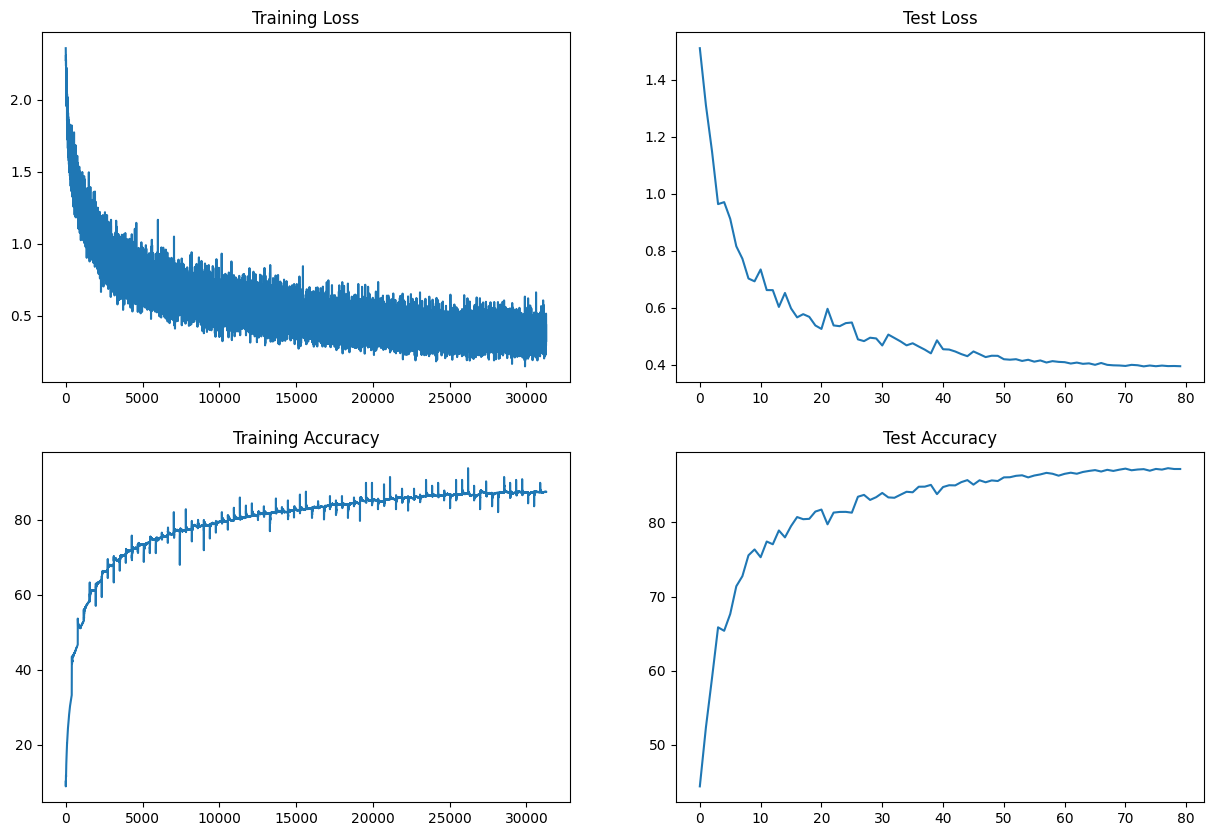

In [13]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")